In [1]:
from ftag.hdf5 import H5Reader # I use ftag tools to read the file
from ftag import Cuts, Flavour, Flavours
from puma.hlplots import AuxResults, Tagger
from puma.utils.vertexing import calculate_vertex_metrics, build_vertices, clean_reco_vertices, clean_truth_vertices
from puma import Histogram, HistogramPlot
import numpy as np

# You need to install JAX to be able to run these.
from puma.utils.billoir_vertex_fit import billoir_vertex_fit, billoir_forward
import jax.numpy as jnp


In [2]:
def leading_jet(jet):
    return jet["jetPtRank"] == 0
    
def jet_flavour(jet, f=""):
    if f == "b": return jet["HadronConeExclTruthLabelID"] == 5
    elif f == "c": return jet["HadronConeExclTruthLabelID"] == 4
    elif f == "light": return jet["HadronConeExclTruthLabelID"] == 0
    else:  return jet ["HadronConeExclTruthLabelID"] >= 0
            


In [3]:
def CalculateDistance(sv_x, sv_y, sv_z, pv_x, pv_y, pv_z):
    
    Lxy = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2)
    Lxyz = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2 +  (sv_z- pv_z)**2)
    return Lxy, Lxyz


# Get the vertex indices and track weights! Which tracks belong to which vertex according? The track origin is used for the cleaning
def GetTrackWeights(track_data, incl_vertexing=False, truth=False, max_sv=1):

    if truth:
        raw_vertex_index = track_data["ftagTruthVertexIndex"] # your raw vertex
        track_origin = track_data["ftagTruthOriginLabel"]

    else:
        # Reco Level
        raw_vertex_index = track_data["GN2v01_20231205_VertexIndex"] # your raw vertex
        track_origin = track_data["GN2v01_20231205_TrackOrigin"]

    # Now clean vertices
    vertex_index  = raw_vertex_index.copy()

    # Prepare mask for filling up
    dummy_track_weights = jnp.zeros((vertex_index.shape[0], max_sv, n_tracks))
    track_weights = jnp.where(dummy_track_weights == 0, np.nan, dummy_track_weights)
    
    for i in range(my_data["tracks"]["GN2v01_20231205_VertexIndex"].shape[0]):

        if truth:
            vertex_index[i] = clean_truth_vertices(
            vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )
        
        else:
            vertex_index[i] = clean_reco_vertices(
            vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )

        vertices = build_vertices(vertex_index[i]) # Convert indices to true/false

        for j in range(0, max_sv):
            try:
                track_weights = track_weights.at[i, j].set(vertices[j])
            except:
                continue


    return track_weights, vertex_index


In [4]:
def TransformData(my_data, n_tracks=40):

    # Function to calculate the track parameters in the perigree representation.
    # Returns data x with the format n_jets x n_tracks x n_parameters
    # The n_parameters will first have the variables needed for the billoir fit, some will have to be build by hand because not everything is available

    n_jets, max_tracks = my_data["tracks"].shape

    track = my_data["tracks"][:, 0:n_tracks]
    jet = my_data["jets"][:] # Only needed if you need to calculate the track phi from dphi.

    # Start by getting a mask of the real tracks

    # Get real tracks

    n_real_tracks = jnp.repeat(my_data["jets"]["n_tracks"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    track_indices = jnp.tile(
         jnp.arange(0,n_tracks,dtype=jnp.int32),
         n_jets,
    ).reshape(n_jets, n_tracks)

    track_mask = jnp.where(track_indices < n_real_tracks, 1, 0)

    # Compute Input Variables for Billoir Vertex Fit
    ### set parameters for dummy tracks to 1. They will be masked out by the track weight and if you choose a very low value the fit will not work well.

    d0 = jnp.where(track_mask == 0, 1, track["d0RelativeToBeamspot"])
    z0 = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspot"]) 
    
    jet_phi = jnp.repeat(jet["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    phi    = track["phi"] # jet_phi + track_dphi # if track phi is missing you may want to do this instead
    phi = jnp.where(track_mask == 0, 1, phi)

    #print(phi[0], " vs ", track["phi"][0])
    #i, j = 1,1
    #print("Check computation of dphi ", jet_phi[i][j] - track["dphi"][i][j], " = ? = ", phi[i][j])

    theta  = jnp.where(track_mask == 0, 1, track["theta"])
    rho    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    d0_error     = jnp.where(track_mask == 0, 1, track["d0RelativeToBeamspotUncertainty"])
    z0_error     = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspotUncertainty"])

    phi_error    = jnp.where(track_mask == 0, 1, track["phiUncertainty"])
    theta_error  = jnp.where(track_mask == 0, 1, track["thetaUncertainty"])

    rho_error    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    track_origin = jnp.where(track_mask == 0, 1, track["GN2v01_aux_TrackOrigin"])
    track_vertex = jnp.where(track_mask == 0, 1, track["GN2v01_aux_VertexIndex"])
     
    x = jnp.stack([d0, z0, phi, theta, rho, d0_error, z0_error, phi_error, theta_error, rho_error, track_origin, track_vertex, n_real_tracks], axis = 2)

    return x, track


In [5]:
def GetCuts(sample):

    if sample == "ttbar":
        sample_str = "$t\\overline{t}$"
        cuts = [
            ("pt", ">=", 20000),
            ("pt", "<=", 250000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            ("HadronConeExclTruthLabelID", ">=", 4),
            ("HadronConeExclTruthLabelID", "<=", 5),
            #("jetPtRank", "==", 0)


        ]
        cut_str = "20 < $p_T$ < 250 GeV, $|\\eta| < 2.5$"
            
    elif sample == "zprime":
        sample_str = "Z'"
        cuts = [
            ("pt", ">=", 250000),
            ("pt", "<=", 6000000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            #("HadronConeExclTruthLabelID", ">=", 4),
            #("HadronConeExclTruthLabelID", "<=", 5)

        ]
        cut_str = "250 < $p_T$ < 6000 GeV, $|\\eta| < 2.5$"
    

    return cuts, cut_str



In [6]:
import h5py

def ListVariables(file):
    with h5py.File(file_path, "r") as f:
        print(f.keys())
        for k in list(f.keys()):
            print(k)
            print(f[k].dtype.fields.keys())

    return 

In [8]:
### Read your data!

sample = "ttbar"
mc = "MC23a"
#my_dir = "GN2_NDIVE/" #"GN2_NDIVE/" "Downloaded/"#
my_dir = "OpenDataset_v0/"
output = "plots/"

n_jets = 50000 #150000
n_tracks = 40 # max 40

## Choose what to read
file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/"+mc+"_"+"new-"+sample+".h5"
#file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/holi.h5"
#file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/MC23a_new-ttbar.h5"
#file_path = "/sdf/home/l/lapereir/software/FTAG/puma/my_scripts/open_ttbar.h5"

# If you need to print out the containers and variables in your file
ListVariables(file_path)

my_cuts, cut_str = GetCuts(sample)


track_var = ["d0", "z0SinTheta", "dphi", "d0Uncertainty", "z0SinThetaUncertainty", "phiUncertainty", "thetaUncertainty", "qOverPUncertainty", "qOverP", "deta", "theta", "dphi", "phi"] # for vertex fit
track_var += ["d0RelativeToBeamspot", "d0RelativeToBeamspotUncertainty","z0RelativeToBeamspot", "z0RelativeToBeamspotUncertainty",  "ftagTruthOriginLabel",  "GN2v01_aux_TrackOrigin", "GN2v01_aux_VertexIndex",  "ftagTruthVertexIndex", "ftagTruthParentBarcode"]

jet_var = ["eventNumber","GN2v00_pb", "GN2v00_pc", "GN2v00_pu", "n_tracks", "jetPtRank", "phi", "eta", "HadronConeExclTruthLabelID", "HadronConeExclExtendedTruthLabelID", "HadronConeExclTruthLabelPdgId", "HadronConeExclTruthLabelLxy", "SV1_Lxy", "JetFitterSecondaryVertex_displacement2d", "SV1_L3d", "JetFitterSecondaryVertex_displacement3d", "JetFitter_nVTX", "mcEventWeight", "nPrimaryVertices"] # phi is needed for vertex fit if track phi is not available # v00 instead of v01
#jet_var +=['PVtoBeam_displacement_X', 'PVtoBeam_displacement_Y', 'PVtoBeam_displacement_Z',]
# "primaryVertexZ", "primaryVertexX", "primaryVertexY", "beamspotX", "beamspotY", "beamspotZ", "Truth_primaryVertexX", "Truth_primaryVertexY", "Truth_primaryVertexZ", 
truth_hadrons = ['pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'HadronFlight_x', 'HadronFlight_y', 'HadronFlight_z','Lxy', 'charge', 'flavour', 'pdgId', 'barcode', 'parentBarcode', 'valid',  'decayVertexDPhi', 'decayVertexDEta'] # 'prodVtx_x', 'prodVtx_y', 'prodVtx_z',  'decayVtx_x', 'decayVtx_y', 'decayVtx_z', 

kinematic_cuts = Cuts.from_list(my_cuts)
print(kinematic_cuts)

## read it!
my_reader = H5Reader(file_path, precision="full", shuffle=False, batch_size=100)
#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "ConeExclFinalLabels" : truth_hadrons, "truth_hadrons" : truth_hadrons}, num_jets=n_jets, cuts=kinematic_cuts)
my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "ConeExclFinalLabels" : truth_hadrons, "truth_hadrons" : truth_hadrons}, cuts=kinematic_cuts)

#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var}, cuts=kinematic_cuts,  num_jets=n_jets) # "ConeExclFinalLabels" : truth_hadrons}, cuts=kinematic_cuts) # num_jets=n_jets,


# now you will be able to read 
# --- data["jets"] with shape n_jets (x n_jet_var tuple)
# --- data["tracks"] with shape n_jets x n_tracks (x n_track_var tuple)
# Note that since jet_var and track_var are stored in a tuple instead of an array when using H5Reader, therefore you will need to convert them to arrays in order to run NDIVE!


<KeysViewHDF5 ['jets', 'tracks']>
jets
dict_keys(['GN120220509_pb', 'GN120220509_pc', 'GN120220509_pu', 'GN2v00_pb', 'GN2v00_pc', 'GN2v00_pu', 'GN2v01_pb', 'GN2v01_pc', 'GN2v01_pu', 'GN2v01_ptau', 'GN2NoAux_pb', 'GN2NoAux_pc', 'GN2NoAux_pu', 'GN2NoAux_ptau', 'GN2Lep_pb', 'GN2Lep_pc', 'GN2Lep_pu', 'GN2Lep_ptau', 'DL1d16052024_pb', 'DL1d16052024_pc', 'DL1d16052024_pu', 'SV1_correctSignificance3d', 'softMuon_pt', 'softMuon_dR', 'softMuon_eta', 'softMuon_phi', 'softMuon_qOverPratio', 'softMuon_momentumBalanceSignificance', 'softMuon_scatteringNeighbourSignificance', 'softMuon_pTrel', 'softMuon_ip3dD0', 'softMuon_ip3dZ0', 'softMuon_ip3dD0Significance', 'softMuon_ip3dZ0Significance', 'softMuon_ip3dD0Uncertainty', 'softMuon_ip3dZ0Uncertainty', 'JetFitterFlip_energyFraction', 'JetFitterFlip_mass', 'JetFitterFlip_significance3d', 'JetFitterFlip_deltaphi', 'JetFitterFlip_deltaeta', 'JetFitterFlip_massUncorr', 'JetFitterFlip_dRFlightDir', 'pt_btagJes', 'eta_btagJes', 'absEta_btagJes', 'scalarSumT

ValueError: Variables {'theta', 'phi', 'ftagTruthParentBarcode', 'd0RelativeToBeamspotUncertainty', 'd0RelativeToBeamspot'} were not found in dataset /tracks in file /fs/ddn/sdf/group/atlas/d/lapereir/GN2/OpenDataset_v0/MC23a_new-ttbar.h5

In [111]:
import pandas as pd

#for n in range (0, 262):
    #print(    my_data["jets"]["primaryVertexX"][n] - my_data["jets"]["beamspotX"][n] - my_data["jets"]["PVtoBeam_displacement_X"][n])

print (my_data["ConeExclFinalLabels"]["HadronFlight_x"].shape)
diff = []
for i in range (0, 100):        
            #if np.isnan(my_data["ConeExclFinalLabels"]["HadronFlight_x"][i][1] - (my_data["ConeExclFinalLabels"]["decayVtx_x"][i][1] - my_data["jets"]["Truth_primaryVertexX"][1])) == False:
            #    diff.append( (my_data["ConeExclFinalLabels"]["HadronFlight_z"][i][1] - (my_data["ConeExclFinalLabels"]["decayVtx_z"][i][1] - my_data["jets"]["Truth_primaryVertexZ"][i] ) )/ my_data["ConeExclFinalLabels"]["HadronFlight_z"][i][1] *100)
    if np.isnan((my_data["ConeExclFinalLabels"]["Lxy"][i][0] - np.sqrt( my_data["ConeExclFinalLabels"]["HadronFlight_x"][i][0]**2 + my_data["ConeExclFinalLabels"]["HadronFlight_y"][i][0]**2  ))) == False:
        diff.append((my_data["ConeExclFinalLabels"]["Lxy"][i][0] - np.sqrt( my_data["ConeExclFinalLabels"]["HadronFlight_x"][i][0]**2 + my_data["ConeExclFinalLabels"]["HadronFlight_y"][i][0]**2  ) ) / my_data["ConeExclFinalLabels"]["Lxy"][i][0] * 100)

print(np.min(diff))
#for n in range (0, 500):
    
#    print(my_data["ConeExclFinalLabels"]["decayVtx_x"][n, 0] - my_data["jets"]["Truth_primaryVertexX"][n], " vs ", my_data["ConeExclFinalLabels"]["HadronFlight_x"][n, 0])


(46252, 5)
-0.07641765725634866


In [132]:
# Find which hadron is actually the parent

#print("Truth Track Parent BarCode", my_data["tracks"]["ftagTruthParentBarcode"][n])
j = 0
diff = []

for n in range(my_data["tracks"]["dphi"].shape[0]):
    if np.isnan(my_data["tracks"]["phi"][n][j] - (my_data["jets"]["phi"][n]) + my_data["tracks"]["dphi"][n][j] ) == False:
        #print(my_data["tracks"]["phi"][n][j] , " vs ", (my_data["jets"]["phi"][n] + my_data["tracks"]["dphi"][n][j]))
        #print(my_data["tracks"]["phi"][n][j] , " vs ", (my_data["jets"]["phi"][n], " + ", my_data["tracks"]["dphi"][n][j]))
        #if abs (my_data["tracks"]["dphi"][n][j]) >= 3.14: print("lerole")
        
        if (abs(my_data["tracks"]["phi"][n][j] - (my_data["jets"]["phi"][n] + my_data["tracks"]["dphi"][n][j]))) > 0.01:
            if abs(my_data["jets"]["phi"][n]) > 3:
                print("track phi ", my_data["tracks"]["phi"][n][j] , " vs ",  my_data["jets"]["phi"][n] + my_data["tracks"]["dphi"][n][j], " = ", (my_data["jets"]["phi"][n], " + ", my_data["tracks"]["dphi"][n][j]), "= ( jet phi + track dphi)")

            diff.append((my_data["tracks"]["phi"][n][j] - (my_data["jets"]["phi"][n] + my_data["tracks"]["dphi"][n][j]) ))

    #print(np.max(my_data["tracks"]["dphi"][:, 0]))
    #print(np.max(diff), " - ", np.min(diff))
    #print(diff)

    print("Truth Hadron Barcode ", my_data["truth_hadrons"]["barcode"][n])
    print(" --> Truth Hadron Parent Barcode ", my_data["truth_hadrons"]["parentBarcode"][n])
    print(" --> Truth Hadron pdgID ", my_data["truth_hadrons"]["pdgId"][n])


Truth Hadron Barcode  [845 848  -1  -1  -1]
 --> Truth Hadron Parent Barcode  [ -1 845  -1  -1  -1]
 --> Truth Hadron pdgID  [511 441  -1  -1  -1]
Truth Hadron Barcode  [2138 2146 2157   -1   -1]
 --> Truth Hadron Parent Barcode  [  -1 2138 2138   -1   -1]
 --> Truth Hadron pdgID  [ 521  421 -421   -1   -1]
Truth Hadron Barcode  [2166 2168   -1   -1   -1]
 --> Truth Hadron Parent Barcode  [  -1 2166   -1   -1   -1]
 --> Truth Hadron pdgID  [-511  421   -1   -1   -1]
Truth Hadron Barcode  [2131   -1   -1   -1   -1]
 --> Truth Hadron Parent Barcode  [-2 -1 -1 -1 -1]
 --> Truth Hadron pdgID  [421  -1  -1  -1  -1]
Truth Hadron Barcode  [1172 1174   -1   -1   -1]
 --> Truth Hadron Parent Barcode  [  -1 1172   -1   -1   -1]
 --> Truth Hadron pdgID  [-511  411   -1   -1   -1]
Truth Hadron Barcode  [1143 1146   -1   -1   -1]
 --> Truth Hadron Parent Barcode  [  -1 1143   -1   -1   -1]
 --> Truth Hadron pdgID  [-521  411   -1   -1   -1]
Truth Hadron Barcode  [387  -1  -1  -1  -1]
 --> Truth Had

In [97]:
for n in range(my_data_prec["tracks"]["dphi"].shape[0]):
    if np.isnan(my_data_prec["tracks"]["phi"][n][j] - (my_data_prec["jets"]["phi"][n]) + my_data_prec["tracks"]["dphi"][n][j] ) == False:
        #print(my_data["tracks"]["phi"][n][j] , " vs ", (my_data["jets"]["phi"][n] + my_data["tracks"]["dphi"][n][j]))
        #print(my_data["tracks"]["phi"][n][j] , " vs ", (my_data["jets"]["phi"][n], " + ", my_data["tracks"]["dphi"][n][j]))
        #if abs (my_data["tracks"]["dphi"][n][j]) >= 3.14: print("lerole")
        
        if (abs(my_data_prec["tracks"]["phi"][n][j] - (my_data_prec["jets"]["phi"][n] + my_data_prec["tracks"]["dphi"][n][j]))) > 0.01:
            if abs(my_data_prec["jets"]["phi"][n]) > 3:
                print("track phi ", my_data_prec["tracks"]["phi"][n][j] , " vs ",  my_data_prec["jets"]["phi"][n] + my_data_prec["tracks"]["dphi"][n][j], " = ", (my_data_prec["jets"]["phi"][n], " + ", my_data_prec["tracks"]["dphi"][n][j]), "= ( jet phi + track dphi)")

            diff.append((my_data_prec["tracks"]["phi"][n][j] - (my_data_prec["jets"]["phi"][n] + my_data_prec["tracks"]["dphi"][n][j]) ))

#print(np.max(my_data["tracks"]["dphi"][:, 0]))
print(np.max(diff), " - ", np.min(diff))
print(diff)


track phi  3.1002655  vs  -3.1829197  =  (-3.0256867, ' + ', -0.15723306) = ( jet phi + track dphi)
6.283185  -  6.283179
[6.283179, 6.283185]


In [10]:
import pandas as pd

# Compare truth variables
jets = my_data["jets"]


truthSV_x = my_data["ConeExclFinalLabels"]["decayVtx_x"][:, 0]
truthSV_y = my_data["ConeExclFinalLabels"]["decayVtx_y"][:, 0]
truthSV_z = my_data["ConeExclFinalLabels"]["decayVtx_z"][:, 0]

truthProdV_x = my_data["ConeExclFinalLabels"]["prodVtx_x"][:, 0]
#truthProdV_y = my_data["ConeExclFinalLabels"]["prodVtx_y"][:, 0]
#truthProdV_z = my_data["ConeExclFinalLabels"]["prodVtx_z"][:, 0]

truthPV_x = my_data["jets"]["Truth_primaryVertexX"]
truthPV_y = my_data["jets"]["Truth_primaryVertexY"]
truthPV_z = my_data["jets"]["Truth_primaryVertexDetectorZ"]

beam_x = my_data["jets"]["beamspotX"]
beam_y = my_data["jets"]["beamspotY"]
beam_z = my_data["jets"]["beamspotZ"]

PV_x = my_data["jets"]["primaryVertexX"]
PV_y = my_data["jets"]["primaryVertexY"]
PV_z = my_data["jets"]["primaryVertexDetectorZ"]
PV_z_v2 = my_data["jets"]["primaryVertexBeamspotZ"]


Truth_Lxy, Truth_Lxyz = CalculateDistance(truthSV_x, truthSV_y, truthSV_z, truthPV_x, truthPV_y, truthPV_z)
# Find jets with more than 1 hadron in them
has_one_hadron = np.isnan(my_data["ConeExclFinalLabels"]["decayVtx_x"][:, 1])
one_hadron = np.where(has_one_hadron)
# Find jets where the leading hadron has a production vertex != production Vertex
outside_pv = np.where(truthPV_x - truthProdV_x != 0)
inside_pv = np.where(truthPV_x - truthProdV_x == 0)

print("Total number of jets = ", len(PV_x))
print("ONLY 1 HADRON IN JET FOR ", len(one_hadron[0])/len(PV_x)*100, " % of the jets")
print("The production vertex matches the PV for ", len(inside_pv[0])/ len(PV_x)*100, " % of the jets")

print(has_one_hadron)
extra_cut = has_one_hadron


ValueError: no field of name prodVtx_x

In [93]:
i = 5

print(my_data["tracks"]["d0RelativeToBeamspot"][i][0],  my_data["tracks"]["d0"][i][0])
print(my_data["tracks"]["z0RelativeToBeamspot"][i][0],  my_data["tracks"]["z0SinTheta"][i][0], my_data["tracks"]["z0SinTheta"][i][0]/np.sin(my_data["tracks"]["theta"][i][0]) )

#print(np.sin(my_data["tracks"]["theta"][i]))
print(PV_z[i] - ( my_data["tracks"]["z0RelativeToBeamspot"][i][0] - my_data["tracks"]["z0SinTheta"][i][0]/np.sin(my_data["tracks"]["theta"][i][0])))


0.41503906 0.4189453
-34.328667 -1.2402344 -1.306769


NameError: name 'PV_z' is not defined

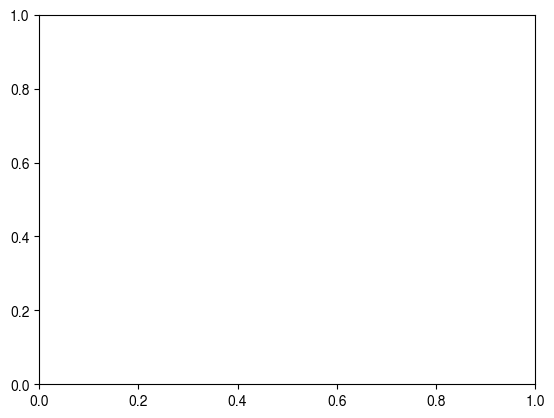

In [10]:

extra_cut = has_one_hadron

for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f) & extra_cut], label="HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    plot_histo.add(truth_hist_v0, reference=False)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)


In [116]:
# Process variables required for Vertex fit
# Get variables for tracks with perigree representation
x, track_data = TransformData(my_data, n_tracks = n_tracks)


In [115]:
inclusive_vertex = True
extra_string = ""
extra = " (Inclusive Vertex)"

if inclusive_vertex == False:
    extra_string = "_NonInclusiveVertex"
    extra = ""

In [21]:
# Get Vertex Index, where are the secondary vertices?
reco_track_weights, reco_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=False, max_sv=1) # if not inclusive you can choose to store more than one vertex i.e. max_sv != 1


In [11]:
truth_track_weights, truth_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=True, max_sv=1) 


In [34]:
for i in range (0, 200):
    print("jet ", i, " -> ", (my_data["jets"]["HadronConeExclTruthLabelPdgId"][i]))


jet  0  ->  -421
jet  1  ->  511
jet  2  ->  0
jet  3  ->  -511
jet  4  ->  -421
jet  5  ->  0
jet  6  ->  0
jet  7  ->  521
jet  8  ->  -511
jet  9  ->  511
jet  10  ->  0
jet  11  ->  0
jet  12  ->  521
jet  13  ->  0
jet  14  ->  421
jet  15  ->  521
jet  16  ->  511
jet  17  ->  0
jet  18  ->  -521
jet  19  ->  521
jet  20  ->  0
jet  21  ->  0
jet  22  ->  511
jet  23  ->  0
jet  24  ->  -4122
jet  25  ->  511
jet  26  ->  0
jet  27  ->  0
jet  28  ->  0
jet  29  ->  0
jet  30  ->  -5122
jet  31  ->  -511
jet  32  ->  4232
jet  33  ->  0
jet  34  ->  0
jet  35  ->  0
jet  36  ->  521
jet  37  ->  0
jet  38  ->  -521
jet  39  ->  0
jet  40  ->  511
jet  41  ->  0
jet  42  ->  -511
jet  43  ->  0
jet  44  ->  0
jet  45  ->  531
jet  46  ->  0
jet  47  ->  0
jet  48  ->  -521
jet  49  ->  531
jet  50  ->  -431
jet  51  ->  0
jet  52  ->  -511
jet  53  ->  521
jet  54  ->  0
jet  55  ->  421
jet  56  ->  -511
jet  57  ->  521
jet  58  ->  0
jet  59  ->  -421
jet  60  ->  0
jet  61  ->

In [64]:
# Get actual vertex index for tracks associated to truth hadron

n = 1 #1

print("Jet # ", n, " event number ",  my_data["jets"]["eventNumber"][n])
print("Jet label ", my_data["jets"]["HadronConeExclTruthLabelID"][n])
print("Jet extended label ", my_data["jets"]["HadronConeExclExtendedTruthLabelID"][n])
print("Jet pdg OD ", my_data["jets"]["HadronConeExclTruthLabelPdgId"][n])


#print("Vertex index from function ", truth_track_weights[n])

print("Truth Track Vertex Index ", my_data["tracks"]["ftagTruthVertexIndex"][n])
print("Truth Track Origin ", my_data["tracks"]["ftagTruthOriginLabel"][n])

print("Truth Track Parent BarCode", my_data["tracks"]["ftagTruthParentBarcode"][n])

print("Truth Hadron Barcode ", my_data["truth_hadrons"]["barcode"][n])
print(" --> Truth Hadron Parent Barcode ", my_data["truth_hadrons"]["parentBarcode"][n])
print(" --> Truth Hadron pdgID ", my_data["truth_hadrons"]["pdgId"][n])

print(" --> Truth ConeExclFinalLables Hadron Barcode ", my_data["ConeExclFinalLabels"]["barcode"][n])
print(" --> Truth ConeExclFinalLables pdg ID ", my_data["ConeExclFinalLabels"]["pdgId"][n])

print(" --> flavors for each of the truth hadrons ", my_data["truth_hadrons"]["flavour"][n])


Jet #  1  event number  83788001
Jet label  5
Jet extended label  5
Jet pdg OD  521
Truth Track Vertex Index  [25 25  3  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Truth Track Origin  [ 4  4  3  2  2  2  2  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Truth Track Parent BarCode [2157 2157 2138   -2   -2   -2   -2   -2   -2   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1]
Truth Hadron Barcode  [2138 2146 2157   -1   -1]
 --> Truth Hadron Parent Barcode  [  -1 2138 2138   -1   -1]
 --> Truth Hadron pdgID  [ 521  421 -421   -1   -1]
 --> Truth ConeExclFinalLables Hadron Barcode  [2138   -1   -1   -1   -1]
 --> Truth ConeExclFinalLables pdg ID  [521  -1  -1  -1  -1]
 --> flavors for each of the truth hadrons  [ 5  4  4 -1 -1]


In [22]:
# Do fit
seed = jnp.zeros((reco_track_weights.shape[0], 3))
vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex (only vertex if incl_vertex = True)


Billoir forward tracks
(40, 13)
Traced<ShapedArray(float32[40,13])>with<DynamicJaxprTrace(level=3/1)>
Estimating vertex from weights:
Traced<ShapedArray(float64[40])>with<DynamicJaxprTrace(level=3/1)>


In [25]:
for i in range (0, 5):
    print(vertex_fit[i, 0] -  my_data["jets"]["beamspotX"][i], " VS")

nan
3.6661375908544658
nan
nan
nan


In [23]:
Lxy, Lxyz = CalculateDistance(vertex_fit[:,0] + beam_x, vertex_fit[:,1] + beam_y, vertex_fit[:,2]  + beam_z, PV_x, PV_y, PV_z)

NameError: name 'beam_x' is not defined

In [ ]:
# Vertex fit with perfect tracks

truth_track_weights, truth_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=True, max_sv=1) 
truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

Lxy_perfect_tracks, Lxyz_perfect_tracks = CalculateDistance(truth_vertex_fit[:,0]  + beam_x, truth_vertex_fit[:,1]  + beam_y, truth_vertex_fit[:,2]  + beam_z, PV_x, PV_y, PV_z)


In [14]:
Vertex_x = np.array(vertex_fit[:, 0] + beam_x)
Vertex_y = np.array(vertex_fit[:, 1] + beam_y)
Vertex_z = np.array(vertex_fit[:, 2] + beam_z)

Vertex_x_error = np.sqrt(vertex_covariance_fit[:, 0, 0])
Vertex_y_error = np.sqrt(vertex_covariance_fit[:, 1, 1])
Vertex_z_error = np.sqrt(vertex_covariance_fit[:, 2, 2])


error_x = np.array(truthSV_x - Vertex_x)
error_y = np.array(truthSV_y - Vertex_y)
error_z = np.array(truthSV_z - Vertex_z)

significance_x = error_x/Vertex_x_error
significance_y = error_y/Vertex_y_error
significance_z = error_z/Vertex_z_error


# What if we use truth tracks instead?

Vertex_x_truth_tracks = np.array(truth_vertex_fit[:, 0] + beam_x)
Vertex_y_truth_tracks = np.array(truth_vertex_fit[:, 1] + beam_y)
Vertex_z_truth_tracks = np.array(truth_vertex_fit[:, 2] + beam_z)



NameError: name 'truth_vertex_fit' is not defined

In [55]:
print(len(Vertex_x))
print(len(extra_cut))

200000
200000


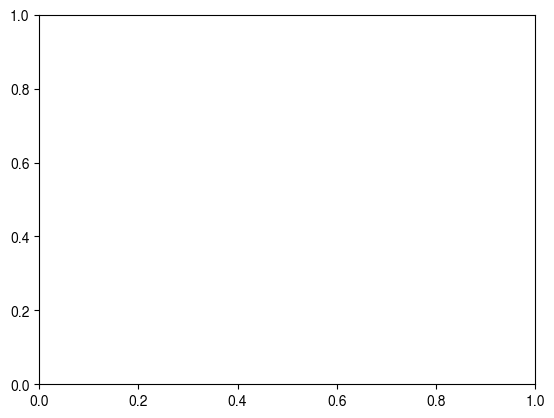

In [23]:
for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

        
    h_r = Histogram( Vertex_x[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV finding)", histtype="step", alpha=1)    
    #h_t = Histogram( Vertex_x_truth_tracks[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV finding)", histtype="step", alpha=1)    
    truth = Histogram( truthSV_x[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)    
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Arbitrary Units",
        xlabel="SV coordinate X",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    #plot_histo.add(h_t, reference=False)
    plot_histo.add(h_r, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_X_"+flavour+extra_string+"_norm.png", transparent=False)


    h_r = Histogram( Vertex_y[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV finding)", histtype="step", alpha=1)    
    #h_t = Histogram( Vertex_y_truth_tracks[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV finding)", histtype="step", alpha=1)    
    truth = Histogram( truthSV_y[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Arbitrary Units",
        xlabel="SV coordinate Y",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    #plot_histo.add(h_t, reference=False)
    plot_histo.add(h_r, reference=False)

        
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Y_"+flavour+extra_string+"_norm.png", transparent=False)


    
    h_r = Histogram( Vertex_z[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV finding)", histtype="step", alpha=1)    
    #h_t = Histogram( Vertex_z_truth_tracks[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV finding)", histtype="step", alpha=1)    
    truth = Histogram( truthSV_z[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)    
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Arbitrary Units",
        xlabel="SV coordinate Z",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-120,120),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth, reference=True)
    #plot_histo.add(h_t, reference=False)
    plot_histo.add(h_r, reference=False)

    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Z_"+flavour+extra_string+"_norm.png", transparent=False)

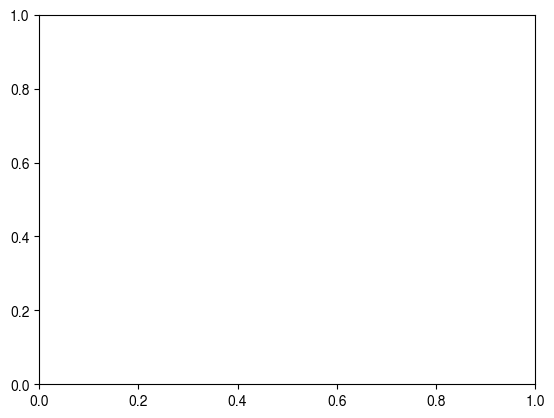

In [16]:
for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    h_x = Histogram( error_x[jet_flavour(jets, f) & extra_cut], label="Vertex X", histtype="step", alpha=1)    
    h_y = Histogram( error_y[jet_flavour(jets, f) & extra_cut], label="Vertex Y", histtype="step", alpha=1)    
    h_z = Histogram( error_z[jet_flavour(jets, f) & extra_cut], label="Vertex Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Billoir Vertex Fit with GN2 (Truth - Predicted) [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_"+flavour+extra_string+".png", transparent=False)

    
    h_x = Histogram( significance_x[jet_flavour(jets, f) & extra_cut], label="Vertex X", histtype="step", alpha=1)    
    h_y = Histogram( significance_y[jet_flavour(jets, f) & extra_cut], label="Vertex Y", histtype="step", alpha=1)    
    h_z = Histogram( significance_z[jet_flavour(jets, f) & extra_cut], label="Vertex Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Arbitrary Units",
        xlabel="GN2 Vertex Significance",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-20,20),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Significance_"+flavour+extra_string+"_norm.png", transparent=False)

/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

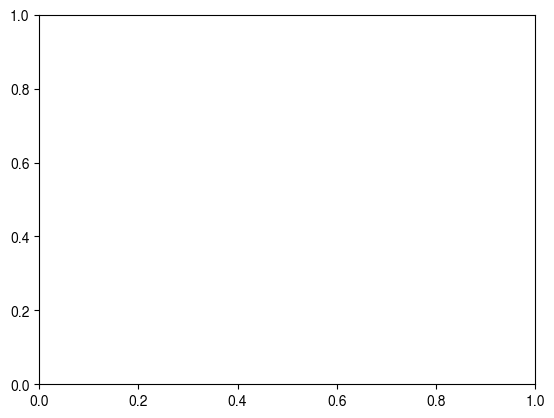

In [22]:
for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxyz[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    #gn2_perfect_hist =  Histogram(Lxyz_perfect_tracks[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)

    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    #plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_"+flavour+extra_string+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f) & extra_cut], label="Truth HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f) & extra_cut], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxy[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    #gn2_perfect_hist =  Histogram(Lxy_perfect_tracks[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    #plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    #plot_histo.add(truth_hist_v0, reference=False)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_"+flavour+extra_string+".png", transparent=False)






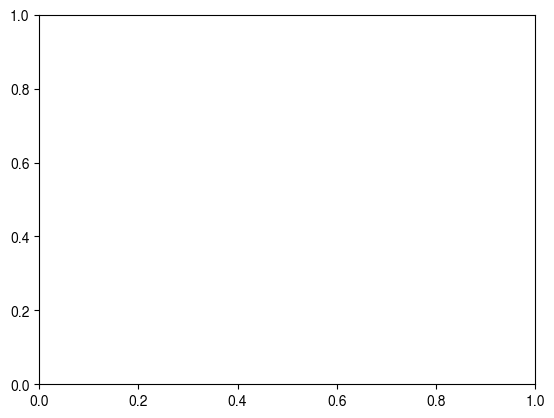

In [18]:

jets = my_data["jets"]


GN2_Lxy_error = (Truth_Lxy - Lxy)
#GN2_Lxy_error_truth = (Truth_Lxy - Lxy_perfect_tracks)

#GN2_buggy_Lxy_error = (truth_vertex_Lxy - buggy_Lxy)

SV1_Lxy_error = (Truth_Lxy - jets["SV1_Lxy"])
JetFitter_Lxy_error = (Truth_Lxy - jets["JetFitterSecondaryVertex_displacement2d"])



for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(GN2_Lxy_error[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    #gn2_hist_truth =  Histogram(GN2_Lxy_error_truth[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)  

    sv1_hist =  Histogram(SV1_Lxy_error[jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxy_error[jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxy Residual [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-10,10),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    #plot_histo.add(gn2_hist_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxy_Residual_"+flavour+extra_string+"_norm.png", transparent=False)


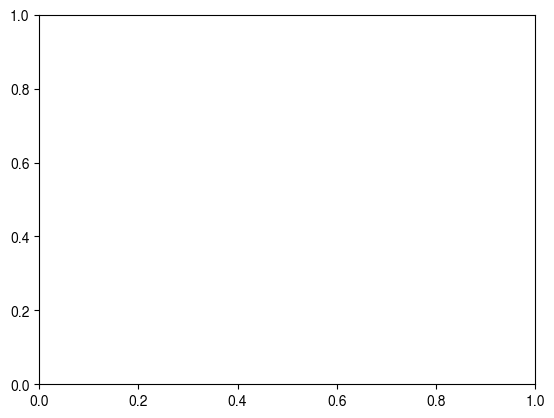

In [69]:


GN2_Lxyz_error = (Truth_Lxyz - Lxyz)
GN2_Lxyz_error_truth = (Truth_Lxyz - Lxyz_perfect_tracks)

#GN2_buggy_Lxy_error = (truth_vertex_Lxy - buggy_Lxy)

SV1_Lxyz_error = (Truth_Lxyz - jets["SV1_L3d"])
JetFitter_Lxyz_error = (Truth_Lxyz - jets["JetFitterSecondaryVertex_displacement3d"])



for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(GN2_Lxyz_error[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(GN2_Lxyz_error_truth[jet_flavour(jets, f) & extra_cut], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)  

    sv1_hist =  Histogram(SV1_Lxyz_error[jet_flavour(jets, f) & extra_cut], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxyz_error[jet_flavour(jets, f) & extra_cut], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="(Truth - Reco) Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(-40,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Error_"+flavour+extra_string+".png", transparent=False)


In [30]:
# Other metrics from Johanne's
#     Dictionary containing the following metrics:
#         n_match: np.ndarray
#             Array of shape (n_jets) containing the number of matched vertices per
#             jet.
#         n_test: np.ndarray
#             Array of shape (n_jets) containing the number of reco vetices per jet.
#         n_ref: np.ndarray
#             Array of shape (n_jets) containing the number of truth vertices per jet.
#         track_overlap: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of
#             overlapping tracks between each matched vertex pair.
#         test_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched reco vertex.
#         ref_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched truth vertex.


vertex_metrics = calculate_vertex_metrics(reco_vertex_index, truth_vertex_index)

n_reco_vertex = vertex_metrics["n_test"] # 1D (jet)
n_truth_vertex = vertex_metrics["n_ref"] # 1D (jet)

n_reco_tracks_per_vertex = vertex_metrics["test_vertex_size"] # 2D (jet, vertex)
n_truth_tracks_per_vertex = vertex_metrics["ref_vertex_size"]  # 2D (jet, vertex)

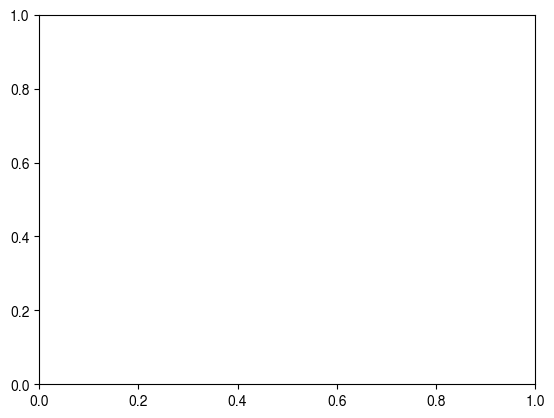

In [77]:
var = np.array(vertex_fit[:, 2])
var_name = "vertex_z_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Number of events",
    xlabel="SV z",
    logy=True,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=40,  # you can also define an integer number for the number of bins
    bins_range=(-30,50),  # only considered if bins is an integer
    norm=False,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+" ",
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig("Histogram_"+var_name+".png", transparent=False)

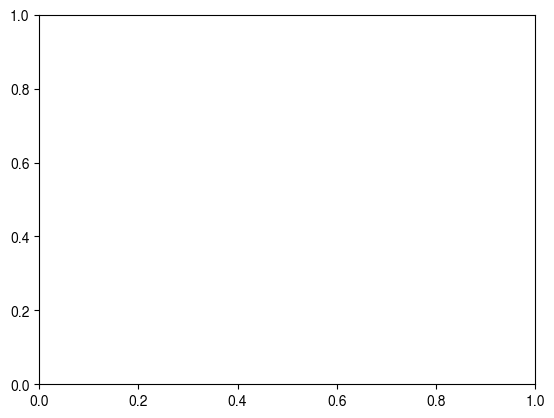

In [42]:
var = n_reco_vertex
var_name = "num_SV_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light-flavour jets", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Arbitrary Units",
    xlabel="GN2 (non-inclusive) # SV",
    logy=False,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=6,  # you can also define an integer number for the number of bins
    bins_range=(0,6),  # only considered if bins is an integer
    norm=True,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+ ", " + cut_str+" (100k jets)",
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig(output+"Histogram_"+var_name+"_norm.png", transparent=False)

In [ ]:
# Alternative method
# Load tagger instead of opening files with the reader

# Vertexing straight from Tagger (Johanne's style). You can run this cell to produce the vertex plots done by Johanne's for the paper but using your samples. You can then use these to compare to your individual plots as validation of the SV finding part.

GN2 = Tagger(
        name="GN2v01",
        label="GN2v01",
        colour="deepskyblue",
        reference=True,
        aux_tasks=["vertexing", "track_origin"]
)

JetFitter = Tagger(
    name="JF",
    label="JetFitter",
    colour="green",
    reference=False,
    aux_tasks=["vertexing"],
)

SV1 = Tagger(
    name="SV1",
    label="SV1",
    colour="pink",
    reference=False,
    aux_tasks=["vertexing"],
)

aux_results = AuxResults(
      sample=sample + "_" + mc, perf_vars=["pt"], remove_nan=True
)

# load tagger from the file object

taggers = [GN2, SV1, GN2, JetFitter]

aux_results.load_taggers_from_file(
    taggers,
    sample_path,
    cuts=cuts,
    num_jets=n_jets,
)

aux_results.atlas_first_tag = "Simulation Internal"

com = "13" if "MC20" in mc else "13.6"
aux_results.atlas_second_tag = (
    "$\\sqrt{s}=" + com + "$ TeV, " + mc + "\n" + sample_str + ", " + cut_str
)

# Make a plot

aux_results.plot_var_vtx_perf(
    vtx_flavours=["bjets"],
    no_vtx_flavours=["ujets"],
    xlabel=r"$p_{T}$ [GeV]",
    perf_var="pt",
    incl_vertexing=True,
)
